## Imports and Drive Mounting

In [18]:
import numpy as np
import pandas as pd
from PIL import Image
import os
import glob
import cv2
import random
import shutil
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import gc
import keras
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array, load_img
import tqdm.notebook as tq
from sklearn.metrics import accuracy_score
import tensorflow as tf
from google.colab import output
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, GlobalAveragePooling2D
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
traffic_sign_labels = {0: '20 km/h',
1:'30 km/h',
2:'50 km/h',
3:'60 km/h',
4:'70 km/h',
5:'80 km/h',
6:'80 km/h end',
7:'100 km/h',
8:'120 km/h',
9:'No overtaking',
10:'No overtaking for trucks',
11:'Crossroad with secondary way',
12:'Main road',
13:'Give way',
14:'Stop',
15:'Road up',
16:'Road - trucks',
17:'No Entry',
18:'Other dangerous',
19:'Turn left',
20:'Turn right',
21:'Winding road',
22:'Hollow road',
23:'Slippery road',
24:'Narrowing road',
25:'Roadwork',
26:'Traffic light',
27:'Pedestrian',
28:'Children',
29:'Cycle',
30:'Snow',
31:'Deer',
32:'End of the limits',
33:'Only right',
34:'Only left',
35:'Only straight',
36:'Only straight and right',
37:'Only straight and left',
38:'Take right',
39:'Take left',
40:'Circle crossroad',
41:'End of overtaking limit',
42:'End of overtaking limit for track'
}

In [7]:
traffic_sign_labels_series = pd.Series(traffic_sign_labels)
traffic_sign_labels_series.head()

0    20 km/h
1    30 km/h
2    50 km/h
3    60 km/h
4    70 km/h
dtype: object

In [8]:
traffic_class_list = ["Class00", "Class01", "Class02", "Class03", "Class04", "Class05", "Class06", "Class07", "Class08", "Class09", 
 "Class10", "Class11", "Class12", "Class13", "Class14", "Class15", "Class16", "Class17", "Class18", "Class19", 
 "Class20", "Class21", "Class22", "Class23", "Class24", "Class25", "Class26", "Class27", "Class28", "Class29", 
 "Class30", "Class31", "Class32", "Class33", "Class34", "Class35", "Class36", "Class37", "Class38", "Class39", 
 "Class40", "Class41", "Class42"]

In [9]:
traffic_class_series = pd.Series(traffic_class_list)
traffic_class_series.head()

0    Class00
1    Class01
2    Class02
3    Class03
4    Class04
dtype: object

In [10]:
traffic_sign_labels_df = pd.concat([traffic_sign_labels_series, 
                                    traffic_class_series], 
                                   axis=1)
traffic_sign_labels_df.reset_index(inplace=True)
traffic_sign_labels_df.rename(columns = {0:'Original_Class_Names', 
                                         1: 'New_Class_Names',
                                         'index': 'Class_Name_Index'}, 
                              inplace = True)

traffic_sign_labels_df.head()

,Class_Name_Index,Original_Class_Names,New_Class_Names
0,0,20 km/h,Class00
1,1,30 km/h,Class01
2,2,50 km/h,Class02
3,3,60 km/h,Class03
4,4,70 km/h,Class04


In [11]:
new_dict = traffic_sign_labels_df['New_Class_Names'].to_dict()

In [12]:
new_dict

{0: 'Class00',
 1: 'Class01',
 2: 'Class02',
 3: 'Class03',
 4: 'Class04',
 5: 'Class05',
 6: 'Class06',
 7: 'Class07',
 8: 'Class08',
 9: 'Class09',
 10: 'Class10',
 11: 'Class11',
 12: 'Class12',
 13: 'Class13',
 14: 'Class14',
 15: 'Class15',
 16: 'Class16',
 17: 'Class17',
 18: 'Class18',
 19: 'Class19',
 20: 'Class20',
 21: 'Class21',
 22: 'Class22',
 23: 'Class23',
 24: 'Class24',
 25: 'Class25',
 26: 'Class26',
 27: 'Class27',
 28: 'Class28',
 29: 'Class29',
 30: 'Class30',
 31: 'Class31',
 32: 'Class32',
 33: 'Class33',
 34: 'Class34',
 35: 'Class35',
 36: 'Class36',
 37: 'Class37',
 38: 'Class38',
 39: 'Class39',
 40: 'Class40',
 41: 'Class41',
 42: 'Class42'}

In [13]:
# Changing working directory

%cd /content/drive/My Drive/Colab Notebooks/DMML2/KaggleData

/content/drive/My Drive/Colab Notebooks/DMML2/KaggleData


In [14]:
# Paths and parameters.

train_data_path = '../NumpyArrays/Cells.npy'
train_label_path = '../NumpyArrays/Labels.npy'
test_data_path = '../NumpyArrays/Cells_test.npy'
test_label_path = '../NumpyArrays/Labels_test.npy'
test_blur3_path = '../NumpyArrays/Cells_test_blur3.npy'
test_blur5_path = '../NumpyArrays/Cells_test_blur5.npy'
test_blur7_path = '../NumpyArrays/Cells_test_blur7.npy'
visualization_path = '/content/drive/My Drive/Colab Notebooks/DMML2/Visualisations'

height = 30
width = 30
channels = 3
classes = 43
n_inputs = height*width*channels

In [24]:
# Loading Train Data.

Cells = np.load(train_data_path)
Labels = np.load(train_label_path)

In [25]:
# Randomize the order of the input images

s = np.arange(Cells.shape[0])
np.random.seed(43)
np.random.shuffle(s)
Cells = Cells[s]
labels = Labels[s]

In [26]:
# Spliting the images into train and validation sets
(X_train, X_val) = Cells[(int)(0.2*len(labels)):], Cells[:(int)(0.2*len(labels))]

X_train = X_train.astype('float32')/255 
X_val = X_val.astype('float32')/255

(y_train, y_val) = labels[(int)(0.2*len(labels)):], labels[:(int)(0.2*len(labels))]

In [27]:
# Using one hote encoding for the train and validation labels

y_train = to_categorical(y_train, 43)
y_val = to_categorical(y_val, 43)

# Model

In [28]:
from keras import layers
from keras import Model
from keras.applications.resnet50 import ResNet50
from keras.optimizers import RMSprop, Adam

#Load the resnet_model model
resnet_model = ResNet50(input_shape = (75, 75, 3), 
                        include_top = False, 
                        weights = None)   

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [29]:
for layer in resnet_model.layers:
     layer.trainable = False
        
# resnet_model.summary()
# last_layer = resnet_model.get_layer('conv5_block3_out')
# print('last layer output shape: ', last_layer.output_shape)
# last_output = last_layer.output

# x = resnet_model.output
# x = GlobalAveragePooling2D()(x)
# x = Dropout(0.5)(x)
# predictions = Dense(43, activation= 'softmax')(x)
resnet_x = resnet_model.output
resnet_x = GlobalAveragePooling2D()(resnet_x)
resnet_x = Dropout(0.5)(resnet_x)
resnet_predictions = Dense(classes, activation= 'softmax')(resnet_x)

# resnet_new_model = Model(resnet_model.input, x) 
resnet_new_model = Model(inputs = resnet_model.input, outputs = resnet_predictions)

resnet_new_model.compile(optimizer = 'adam', 
              loss = 'categorical_crossentropy', 
              metrics = ['acc'])

In [30]:
#using ten epochs for the training and saving the accuracy for each epoch
%%time
epochs = 20
history = resnet_new_model.fit(X_train, y_train, batch_size=32, 
                        epochs=epochs, validation_data = (X_val, y_val))

Train on 31368 samples, validate on 7841 samples
Epoch 1/20
31368/31368 [==============================] - 38s 1ms/step - loss: 4.6981 - acc: 0.0562 - val_loss: 259.7213 - val_acc: 0.0284
Epoch 2/20
31368/31368 [==============================] - 36s 1ms/step - loss: 4.3587 - acc: 0.0667 - val_loss: 271.9027 - val_acc: 0.0307
Epoch 3/20
31368/31368 [==============================] - 36s 1ms/step - loss: 4.2474 - acc: 0.0715 - val_loss: 183.6002 - val_acc: 0.0286
Epoch 4/20
31368/31368 [==============================] - 36s 1ms/step - loss: 4.2045 - acc: 0.0735 - val_loss: 232.7223 - val_acc: 0.0221
Epoch 5/20
31368/31368 [==============================] - 36s 1ms/step - loss: 4.2142 - acc: 0.0719 - val_loss: 207.6004 - val_acc: 0.0069
Epoch 6/20
31368/31368 [==============================] - 36s 1ms/step - loss: 4.2068 - acc: 0.0753 - val_loss: 186.7837 - val_acc: 0.0304
Epoch 7/20
31368/31368 [==============================] - 36s 1ms/step - loss: 4.1850 - acc: 0.0737 - val_loss: 210.3

KeyboardInterrupt: ignored

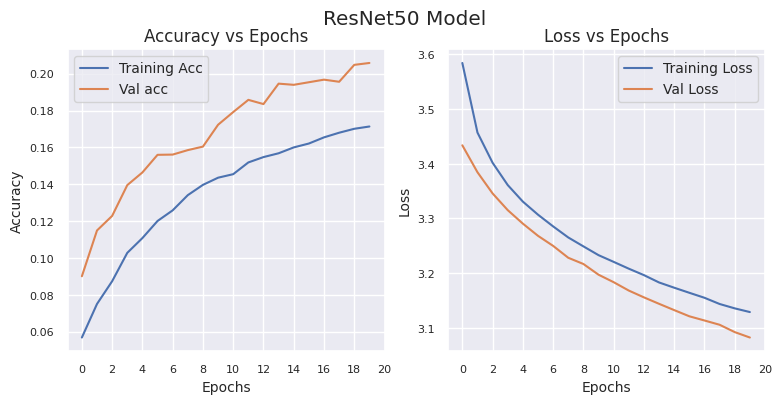

In [26]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(9, 4), dpi=100)
 
fig.suptitle("ResNet50 Model", 
             fontdict = {'fontsize': 10, 'fontweight' : 3})
 
ax[0].set_title('Accuracy vs Epochs')
ax[0].plot(history.history['acc'], label='Training Acc')
ax[0].plot(history.history['val_acc'], label='Val acc')
ax[0].set_xlabel('Epochs', fontsize=10)
ax[0].set_ylabel('Accuracy', fontsize=10)
ax[0].legend(fontsize=10)
ax[0].tick_params(axis='both', which='major', labelsize=8)
ax[0].xaxis.set_ticks(np.arange(0, 21, 2))
 
ax[1].set_title('Loss vs Epochs')
ax[1].plot(history.history['loss'], label='Training Loss')
ax[1].plot(history.history['val_loss'], label='Val Loss')
ax[1].set_xlabel('Epochs', fontsize=10)
ax[1].set_ylabel('Loss', fontsize=10)
ax[1].legend(fontsize=10)
ax[1].tick_params(axis='both', which='major', labelsize=8)
ax[1].xaxis.set_ticks(np.arange(0, 21, 2))
 
fig.savefig(os.path.join(visualization_path, 'ResNet50_acc_loss.png'), 
            dpi=300, bbox_inches='tight')

In [27]:
# Loading test data from saved files.

# X_test = np.load(test_data_path)
# y_test = np.load(test_label_path)

# Loading test data from saved array files.
 
X_test = np.load(test_data_path)
X_test_3 = np.load(test_blur3_path)
X_test_5 = np.load(test_blur5_path)
X_test_7 = np.load(test_blur7_path)
y_test = np.load(test_label_path)

In [28]:
# X_test = X_test.astype('float32')/255 

X_test = X_test.astype('float32')/255 
X_test_3 = X_test_3.astype('float32')/255 
X_test_5 = X_test_5.astype('float32')/255 
X_test_7 = X_test_7.astype('float32')/255 

In [29]:
# Predicting output.

pred = resnet_new_model.predict(X_test)
# print(pred.shape)
pred_3 = resnet_new_model.predict(X_test_3)
pred_5 = resnet_new_model.predict(X_test_5)
pred_7 = resnet_new_model.predict(X_test_7)

In [30]:
from sklearn.metrics import classification_report
  
traffic_sign_labels_list = [new_dict[i] for i in range(len(new_dict))]

resnet_class = classification_report(y_test, np.argmax(pred, axis=1), 
                            target_names = traffic_sign_labels_list, output_dict = True)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [31]:
resnet_class_3 = classification_report(y_test, np.argmax(pred_3, axis=1), 
                            target_names = traffic_sign_labels_list, output_dict = True)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [32]:
resnet_class_5 = classification_report(y_test, np.argmax(pred_5, axis=1), 
                            target_names = traffic_sign_labels_list, output_dict = True)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [33]:
resnet_class_7 = classification_report(y_test, np.argmax(pred_7, axis=1), 
                            target_names = traffic_sign_labels_list, output_dict = True)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [34]:
resnet_df_top = pd.DataFrame(resnet_class).transpose().sort_values(by='f1-score', ascending=False)[:5]
resnet_df_top.reset_index(inplace=True)
resnet_df_bottom = pd.DataFrame(resnet_class).transpose().sort_values(by='f1-score', ascending=True)[:5]
resnet_df_bottom.reset_index(inplace=True)

resnet_df_top_3 = pd.DataFrame(resnet_class_3).transpose().sort_values(by='f1-score', ascending=False)[:5]
resnet_df_top_3.reset_index(inplace=True)
resnet_df_bottom_3 = pd.DataFrame(resnet_class_3).transpose().sort_values(by='f1-score', ascending=True)[:5]
resnet_df_bottom_3.reset_index(inplace=True)

resnet_df_top_5 = pd.DataFrame(resnet_class_5).transpose().sort_values(by='f1-score', ascending=False)[:5]
resnet_df_top_5.reset_index(inplace=True)
resnet_df_bottom_5 = pd.DataFrame(resnet_class_5).transpose().sort_values(by='f1-score', ascending=True)[:5]
resnet_df_bottom_5.reset_index(inplace=True)

resnet_df_top_7 = pd.DataFrame(resnet_class_7).transpose().sort_values(by='f1-score', ascending=False)[:5]
resnet_df_top_7.reset_index(inplace=True)
resnet_df_bottom_7 = pd.DataFrame(resnet_class_7).transpose().sort_values(by='f1-score', ascending=True)[:5]
resnet_df_bottom_7.reset_index(inplace=True)

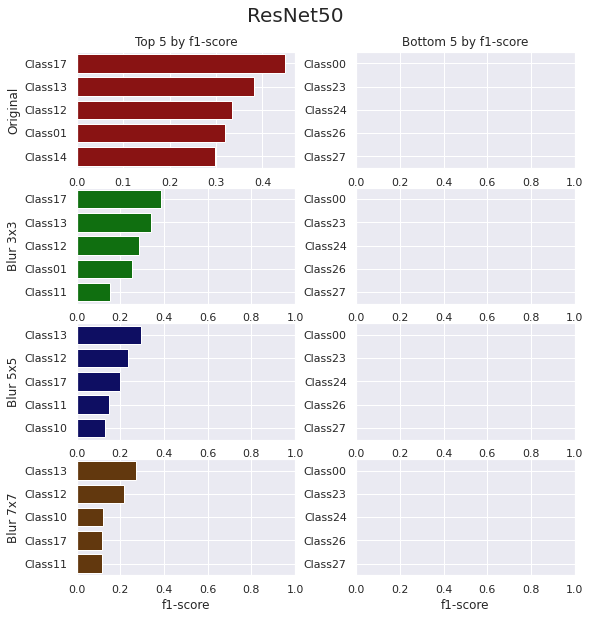

In [35]:
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(8, 8))

sns.barplot(y = 'index', x = 'f1-score', data=resnet_df_top, ax=ax[0,0], color='#9c0000')
ax[0,0].set_ylabel('Original')
ax[0,0].set_title('Top 5 by f1-score')
ax[0,0].set_xlabel("")
# ax[0,0].get_xaxis().set_visible(False)
ax[0,0].grid(True)

sns.barplot(y = 'index', x = 'f1-score', data=resnet_df_bottom, ax=ax[0,1], color='#f29999')
ax[0,1].set_xlim([0, 1.0])
ax[0,1].set_title('Bottom 5 by f1-score')
# ax[0,1].get_xaxis().set_visible(False)
ax[0,1].set_xlabel("")
ax[0,1].set_ylabel("")
# ax[0,1].get_yaxis().set_visible(False)
ax[0,1].grid(True)

sns.barplot(y = 'index', x = 'f1-score', data=resnet_df_top_3, ax=ax[1,0], color='#007F00')
ax[1,0].set_xlabel("")
ax[1,0].set_ylabel('Blur 3x3')
ax[1,0].set_xlim([0, 1.0])
# ax[1,0].get_xaxis().set_visible(False)
ax[1,0].grid(True)

sns.barplot(y = 'index', x = 'f1-score', data=resnet_df_bottom_3, ax=ax[1,1], color='#7fe57f')
ax[1,1].set_xlim([0, 1.0])
# ax[1,1].get_xaxis().set_visible(False)
ax[1,1].set_xlabel("")
ax[1,1].set_ylabel("")
ax[1,1].grid(True)
# ax[1,1].get_yaxis().set_visible(False)

sns.barplot(y = 'index', x = 'f1-score', data=resnet_df_top_5, ax=ax[2,0], color='#000070')
ax[2,0].set_xlabel("")
ax[2,0].set_ylabel('Blur 5x5')
ax[2,0].set_xlim([0, 1.0])
# ax[2,0].get_xaxis().set_visible(False)
ax[2,0].grid(True)

sns.barplot(y = 'index', x = 'f1-score', data=resnet_df_bottom_5, ax=ax[2,1], color='#9999f2')
ax[2,1].set_xlim([0, 1.0])
# ax[2,1].get_xaxis().set_visible(False)
ax[2,1].set_xlabel("")
ax[2,1].set_ylabel("")
ax[2,1].grid(True)
# ax[2,1].get_yaxis().set_visible(False)

sns.barplot(y = 'index', x = 'f1-score', data=resnet_df_top_7, ax=ax[3,0], color='#703800')
ax[3,0].set_ylabel('Blur 7x7')
ax[3,0].set_xlim([0, 1.0])
ax[3,0].grid(True)

sns.barplot(y = 'index', x = 'f1-score', data=resnet_df_bottom_7, ax=ax[3,1], color='#f2c599')
ax[3,1].set_xlim([0, 1.0])
ax[3,1].set_ylabel("")
ax[3,1].grid(True)
# ax[3,1].get_yaxis().set_visible(False)

fig.tight_layout(pad=0)
fig.suptitle('ResNet50', position=(0.5, 1.05), fontsize=20)

fig.savefig(os.path.join(visualization_path, 'ResNet50_f1_scores.png'), 
            dpi=300, bbox_inches='tight')